# Определение возраста покупателей

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:

Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;

Контролировать добросовестность кассиров при продаже алкоголя.

Постройте модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.

## Исследовательский анализ данных

In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import warnings
warnings.filterwarnings('ignore')
plt.style.use('dark_background')

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

# df = pd.read_csv('/content/drive/MyDrive/csv/faces_labels.csv')
# image_ = ImageDataGenerator(rescale=1./255)
# image = image_.flow_from_dataframe(
#         dataframe=df,
#         directory='/content/drive/MyDrive/csv/faces_jpg/',
#         x_col='file_name',
#         y_col='real_age',
#         target_size=(224, 224),
#         batch_size=32,
#         class_mode='raw',
#         seed=42)

In [ ]:
df = pd.read_csv('/datasets/faces/labels.csv')
image_ = ImageDataGenerator(rescale=1./255)
image = image_.flow_from_dataframe(
        dataframe=df,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=42)

Found 7591 validated image filenames.


In [ ]:
df.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


Целевая таблица представляет соответствие названия .jpg файла на котором лица покупателей c возрастом этих покупателей указанным в колонке 'real_age'. Всего 7591 наблюдений

In [ ]:
df.isna().mean()

file_name    0.0
real_age     0.0
dtype: float64

In [ ]:
df.duplicated().sum()

0

Пропусков и явных дубликатов в данных не наблюдаем

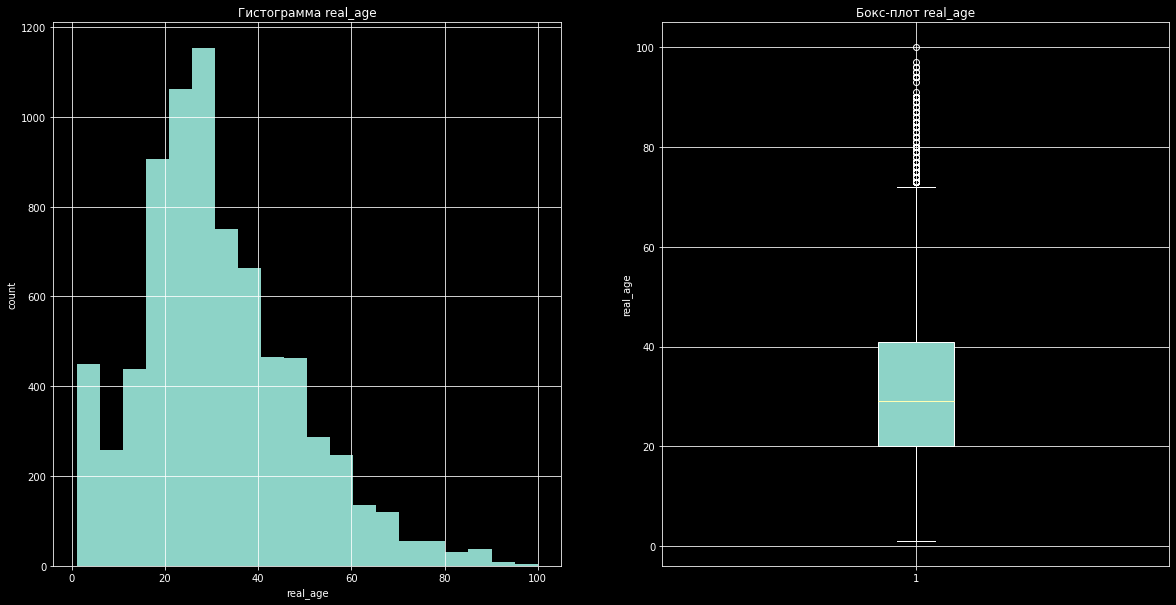

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

ax[0].hist(df['real_age'], bins=20)
ax[0].set_title('Гистограмма real_age')
ax[0].set_xlabel('real_age')
ax[0].set_ylabel('count')
ax[0].grid(True)

ax[1].boxplot(df['real_age'], patch_artist=True)
ax[1].set_ylabel('real_age')
ax[1].set_title('Бокс-плот real_age')
ax[1].grid(True)
plt.show()

In [ ]:
df['real_age'].describe()

count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64

Распределение возраста напоминает нормальное распределение слегка смещенное к левому краю, разброс возраста варьируется от 1 года до 100 лет, в среднем 31

Значения находящиеся в правой части распределения слегка выбиваются из общей массы

Первые 5 изображений находящихся в директории:

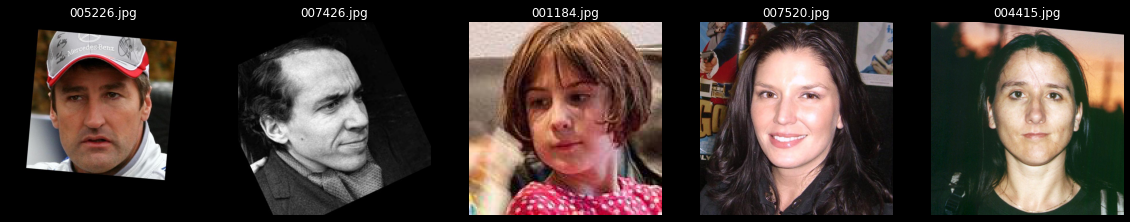

In [ ]:
directory = '/datasets/faces/final_files/'
# directory = '/content/drive/MyDrive/csv/faces_jpg/'
files = os.listdir(directory)

fig, axes = plt.subplots(1, 5, figsize=(20, 10))
for i, file in enumerate(files[:5]):
    img_path = os.path.join(directory, file)
    img = plt.imread(img_path)
    plt.subplot(1, 5, i+1)
    plt.imshow(img)
    plt.title(file)
    plt.axis('off')
plt.show()

Вывод EDA:

-Целевая таблица представляет соответствие названия .jpg файла на котором лица покупателей c возрастом этих покупателей указанным в колонке 'real_age'. Всего 7591 наблюдений

-Распределение возраста напоминает нормальное распределение слегка смещенное к левому краю, разброс возраста варьируется от 1 года до 100 лет, в среднем 31

-Значения находящиеся в правой части распределения слегка выбиваются из общей массы

-Фотографии находящиеся в директории выглядят +- корректно (виднеются некоторые особенности с фотографиями, некоторые из них в формате ЧБ, небольшим наклоном и чуть меньшим размером)

## Обучение модели

Фунции обучения и его результат на GPU-тренажёре яндекса:

```python

from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Flatten,  Conv2D, Flatten, AvgPool2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
import numpy as np
from tensorflow.keras.models import Sequential
import tensorflow
import pandas as pd


def load_train(path):
    df = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, horizontal_flip=True, rescale=1./255)
    train_datagen_flow = datagen.flow_from_dataframe(
        dataframe=df,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=42)

    return train_datagen_flow

def load_test(path):
    df = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    test_datagen_flow = datagen.flow_from_dataframe(
        dataframe=df,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=42)

    return test_datagen_flow

def create_model(input_shape):
    backbone = ResNet50(
        input_shape=input_shape,
        weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
        include_top=False)


    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    optimizer = Adam(lr=0.001)

    model.compile(
        optimizer=optimizer, loss='mean_squared_error',
        metrics=['mae']
    )

    return model

def train_model(
    model,
    train_datagen_flow,
    test_datagen_flow,
    batch_size=None,
    epochs=15,
    steps_per_epoch=None,
    validation_steps=None):

    model.fit(
        train_datagen_flow,
        validation_data=test_datagen_flow,
        batch_size=batch_size,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        verbose=2,
    )
    return model



```

```

Found 5694 validated image filenames.
Found 1897 validated image filenames.

Train for 178 steps, validate for 60 steps
Epoch 1/15
178/178 - 61s - loss: 228.6469 - mae: 11.5218 - val_loss: 283.4557 - val_mae: 12.9899
Epoch 2/15
178/178 - 49s - loss: 152.8507 - mae: 9.4534 - val_loss: 306.7081 - val_mae: 13.0043
Epoch 3/15
178/178 - 50s - loss: 128.7868 - mae: 8.6756 - val_loss: 290.7869 - val_mae: 12.8645
Epoch 4/15
178/178 - 50s - loss: 110.2690 - mae: 8.0363 - val_loss: 364.2795 - val_mae: 14.1511
Epoch 5/15
178/178 - 50s - loss: 89.8889 - mae: 7.2055 - val_loss: 173.0956 - val_mae: 9.4597
Epoch 6/15
178/178 - 50s - loss: 82.5950 - mae: 6.9076 - val_loss: 174.7974 - val_mae: 10.4303
Epoch 7/15
178/178 - 49s - loss: 76.0205 - mae: 6.6077 - val_loss: 165.9916 - val_mae: 9.6063
Epoch 8/15
178/178 - 49s - loss: 68.7058 - mae: 6.2975 - val_loss: 123.9958 - val_mae: 8.3484
Epoch 9/15
178/178 - 49s - loss: 59.0637 - mae: 5.8943 - val_loss: 104.3324 - val_mae: 7.6254
Epoch 10/15
178/178 - 50s - loss: 47.7327 - mae: 5.2994 - val_loss: 113.3843 - val_mae: 7.8822
Epoch 11/15
178/178 - 48s - loss: 40.2059 - mae: 4.8893 - val_loss: 102.8622 - val_mae: 7.6981
Epoch 12/15
178/178 - 46s - loss: 34.3452 - mae: 4.5161 - val_loss: 103.9083 - val_mae: 7.7319
Epoch 13/15
178/178 - 49s - loss: 30.7669 - mae: 4.2389 - val_loss: 95.6184 - val_mae: 7.3393
Epoch 14/15
178/178 - 49s - loss: 25.9250 - mae: 3.9504 - val_loss: 89.0863 - val_mae: 7.1237
Epoch 15/15
178/178 - 49s - loss: 25.8408 - mae: 3.8797 - val_loss: 84.5486 - val_mae: 6.9322

60/60 - 12s - loss: 84.5486 - mae: 6.9322
Test MAE: 6.9322

```

## Анализ обученной модели

Архитектура сверточной нейронной сети глубокого обучения с элементами остаточного обучения ResNet50 весьма качественно справляется с данной задачей компьютерного зрения. Возможно в качестве улучшения метрики

-попробовать другие алгоритмы популярных сетей для обработки изображений: AlexNet, ZFNet, VGG, GoogLeNet;

-добавить полносвязных слоев в сторону усложнения сети и увеличения кол-ва параметров которые может подобрать алгоритм;

-увеличить кол-во эпох обучения

-добавление данных для обучающей выборки

